In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv
/kaggle/input/data-aggregation-ipynb/create_feature_train_ver2.pkl
/kaggle/input/data-aggregation-ipynb/create_feature_test_kaggle_ver2.pkl
/kaggle/input/data-aggregation-ipynb/__results__.html
/kaggle/input/data-aggregation-ipynb/__notebook__.ipynb
/kaggle/input/data-aggregation-ipynb/__output__.json
/kaggle/input/data-aggregation-ipynb/custom.css


# Libs

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, roc_auc_score, confusion_matrix
import copy
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

# Load data

In [3]:
train_full = pd.read_pickle('/kaggle/input/data-aggregation-ipynb/create_feature_train_ver2.pkl')

temp, test = train_test_split(train_full, test_size = 0.15)
train, valid = train_test_split(temp, test_size = 0.2)
train.shape, valid.shape, test.shape

((209107, 534), (52277, 534), (46127, 534))

In [4]:
test_kaggle = pd.read_pickle('/kaggle/input/data-aggregation-ipynb/create_feature_test_kaggle_ver2.pkl')
test_kaggle.shape

(48744, 533)

# Draft

In [5]:
arr = [0,5,2,-1,10]
np.maximum(arr, 0.5)

array([ 0.5,  5. ,  2. ,  0.5, 10. ])

In [6]:
np.log(0.085413/0.122575)

-0.36122477350343973

# Funcs

In [7]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        try:
#     for ivars in ['CARD_M3CARD_IS_DPD_UNDER_120_MEAN']:
            if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
                binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
                d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
            else:
                d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

            # missing
            if d0.isnull().sum().sum() > 0 :
                try:
                    d0['x'] = d0['x'].cat.add_categories('Missing')
                    d0['x'].fillna('Missing', inplace =True)
                except:
    #                 print('var ', ivars)
                    d0['x'].fillna('Missing', inplace =True)


            # Calculate the number of events in each group (bin)
            d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
            d.columns = ['Cutoff', 'N', 'Events']

            # Calculate % of events in each group.
            d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

            # Calculate the non events in each group.
            d['Non-Events'] = d['N'] - d['Events']
            # Calculate % of non events in each group.
            d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

            # Calculate WOE by taking natural log of division of % of non-events and % of events
            d['WoE'] = np.log(d['% of Events']/d['% of Non-Events']) ## ln(good/bad) => event : good
            d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
            d.insert(loc=0, column='Variable', value=ivars)
    #         print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
            temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
            newDF=pd.concat([newDF,temp], axis=0)
            woeDF=pd.concat([woeDF,d], axis=0)
        
        except:
            print('Fail ', ivars)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [8]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 4)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 4)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 4)))
    plt.plot([0, 1], [0, 1], '--', color = 'blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=1)

# Select feature with best IV

In [9]:
train[['PREV_PREV_CREDIT_APPL_RATIO_MAX',
       'PREV_PREV_INTERESTS_RATE_MEAN', 
       'PREV_D365_PREV_INTERESTS_RATE_MEAN']] = train[['PREV_PREV_CREDIT_APPL_RATIO_MAX',
                                                       'PREV_PREV_INTERESTS_RATE_MEAN', 
                                                       'PREV_D365_PREV_INTERESTS_RATE_MEAN']].replace([np.inf], 99999)

train[['PREV_PREV_CREDIT_APPL_RATIO_MAX', 
       'PREV_PREV_INTERESTS_RATE_MEAN', 
       'PREV_D365_PREV_INTERESTS_RATE_MEAN']] = train[['PREV_PREV_CREDIT_APPL_RATIO_MAX', 
                                                       'PREV_PREV_INTERESTS_RATE_MEAN', 
                                                       'PREV_D365_PREV_INTERESTS_RATE_MEAN']].replace([-np.inf], -99999)


test_kaggle[['PREV_PREV_CREDIT_APPL_RATIO_MAX',
       'PREV_PREV_INTERESTS_RATE_MEAN', 
       'PREV_D365_PREV_INTERESTS_RATE_MEAN']] = test_kaggle[['PREV_PREV_CREDIT_APPL_RATIO_MAX',
                                                       'PREV_PREV_INTERESTS_RATE_MEAN', 
                                                       'PREV_D365_PREV_INTERESTS_RATE_MEAN']].replace([np.inf], 99999)

test_kaggle[['PREV_PREV_CREDIT_APPL_RATIO_MAX', 
       'PREV_PREV_INTERESTS_RATE_MEAN', 
       'PREV_D365_PREV_INTERESTS_RATE_MEAN']] = test_kaggle[['PREV_PREV_CREDIT_APPL_RATIO_MAX', 
                                                       'PREV_PREV_INTERESTS_RATE_MEAN', 
                                                       'PREV_D365_PREV_INTERESTS_RATE_MEAN']].replace([-np.inf], -99999)

In [10]:
newDF, woeDF = iv_woe(data = train.drop(columns = ['SK_ID_CURR']),
                        target = 'TARGET')

In [11]:
newDF

,Variable,IV
0,NAME_CONTRACT_TYPE,0.017245
0,CODE_GENDER,0.040828
0,FLAG_OWN_CAR,0.005939
0,FLAG_OWN_REALTY,0.000520
0,CNT_CHILDREN,0.001511
...,...,...
0,CARD_M3CARD_IS_DPD_SUM,0.005262
0,CARD_M3CARD_IS_DPD_UNDER_120_MEAN,0.006123
0,CARD_M3CARD_IS_DPD_UNDER_120_SUM,0.006108
0,CARD_M3CARD_IS_DPD_OVER_120_MEAN,0.003365


In [12]:
newDF.to_excel('Feature_full_IV.xlsx')

In [13]:
newDF[newDF['IV']>= 0.02]

,Variable,IV
0,CODE_GENDER,0.040828
0,AMT_CREDIT,0.045123
0,AMT_ANNUITY,0.024486
0,AMT_GOODS_PRICE,0.091694
0,NAME_INCOME_TYPE,0.060109
...,...,...
0,CARD_M3CNT_DRAWINGS_CURRENT_MEAN,0.026427
0,CARD_M3CNT_DRAWINGS_CURRENT_SUM,0.025484
0,CARD_M3CNT_DRAWINGS_POS_CURRENT_MEAN,0.022720
0,CARD_M3BALANCE_LIMIT_RATIO_MIN,0.064488


In [14]:
woeDF

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,NAME_CONTRACT_TYPE,0,189256,15920.0,0.937574,173336.0,0.902195,0.038465,1.360832e-03
1,NAME_CONTRACT_TYPE,1,19851,1060.0,0.062426,18791.0,0.097805,-0.448989,1.588464e-02
0,CODE_GENDER,0,71384,7325.0,0.431390,64059.0,0.333420,0.257609,2.523790e-02
1,CODE_GENDER,1,137721,9655.0,0.568610,128066.0,0.666570,-0.158949,1.557059e-02
2,CODE_GENDER,2,2,0.0,0.000029,2.0,0.000010,1.039826,1.979478e-05
...,...,...,...,...,...,...,...,...,...
0,CARD_M3CARD_IS_DPD_OVER_120_SUM,0.0,57489,5068.0,0.298469,52421.0,0.272846,0.089759,2.299925e-03
1,CARD_M3CARD_IS_DPD_OVER_120_SUM,1.0,136,11.0,0.000648,125.0,0.000651,-0.004298,1.199301e-08
2,CARD_M3CARD_IS_DPD_OVER_120_SUM,2.0,169,11.0,0.000648,158.0,0.000822,-0.238579,4.164444e-05
3,CARD_M3CARD_IS_DPD_OVER_120_SUM,3.0,114,9.0,0.000530,105.0,0.000547,-0.030615,5.044848e-07


In [15]:
woeDF.to_excel('Feature_full_WOE.xlsx')

In [16]:
transform_woe_df = woeDF[woeDF['Variable'].isin(newDF[newDF['IV']>= 0.02]['Variable'])]
transform_woe_df.shape

(1969, 9)

In [17]:
transform_woe_df.head()

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,CODE_GENDER,0,71384,7325.0,0.431390,64059.0,0.333420,0.257609,0.025238
1,CODE_GENDER,1,137721,9655.0,0.568610,128066.0,0.666570,-0.158949,0.015571
2,CODE_GENDER,2,2,0.0,0.000029,2.0,0.000010,1.039826,0.000020
0,AMT_CREDIT,"(44999.999, 180000.0]",22520,1507.0,0.088751,21013.0,0.109370,-0.208900,0.004307
1,AMT_CREDIT,"(180000.0, 254700.0]",21722,1708.0,0.100589,20014.0,0.104171,-0.034989,0.000125


In [18]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CARD_M3BALANCE_LIMIT_RATIO_MIN,CARD_M3BALANCE_LIMIT_RATIO_MAX,CARD_M3DRAWING_LIMIT_RATIO_MIN,CARD_M3DRAWING_LIMIT_RATIO_MAX,CARD_M3CARD_IS_DPD_MEAN,CARD_M3CARD_IS_DPD_SUM,CARD_M3CARD_IS_DPD_UNDER_120_MEAN,CARD_M3CARD_IS_DPD_UNDER_120_SUM,CARD_M3CARD_IS_DPD_OVER_120_MEAN,CARD_M3CARD_IS_DPD_OVER_120_SUM
283030,427822,0.0,0,0,1,0,0,202500.0,225000.0,8613.0,...,0.000000,0.055091,0.000000,0.055334,0.0,0.0,0.0,0.0,0.0,0.0
112938,230995,1.0,0,0,1,0,0,225000.0,450000.0,50904.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147314,270801,0.0,0,1,0,0,0,180000.0,633681.0,30951.0,...,0.023257,1.011317,0.007333,0.254417,0.0,0.0,0.0,0.0,0.0,0.0
190437,320804,1.0,0,1,0,0,0,247500.0,1096020.0,56092.5,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
39691,145953,0.0,0,0,1,0,1,225000.0,1206954.0,35419.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# WOE Transformation

In [19]:
final_list = list(transform_woe_df['Variable'].unique())
print(len(final_list))
keep_cols_dev = final_list + ['TARGET', 'SK_ID_CURR']
keep_cols_test_kaggle = final_list + ['SK_ID_CURR']
print(len(keep_cols_dev), len(keep_cols_test_kaggle))

228
230 229


In [20]:
map_transform_dict = {}
for idx in range(transform_woe_df.shape[0]):
    var = transform_woe_df.iloc[idx]['Variable']
    cutoff = transform_woe_df.iloc[idx]['Cutoff']
    woe = float(transform_woe_df.iloc[idx]['WoE'])
    
    if var not in map_transform_dict:
        map_transform_dict[var] = [[], []]  ## cutoff, woe
    if str(cutoff) == 'Missing':
        map_transform_dict[var][0].append('Missing')
    elif '(' not in str(cutoff):
        map_transform_dict[var][0].append(cutoff)
    elif '(' in str(cutoff):
        cutoff_str = str(cutoff).replace('(', '').replace(']', '')
        upper = cutoff_str.split(',')[0]
        lower = cutoff_str.split(',')[-1]
        map_transform_dict[var][0].append([upper, lower])
    map_transform_dict[var][1].append(woe)

In [21]:
from tqdm import tqdm
def map_woe_values(data, map_transform_dict):
    data = data.reset_index().drop(columns = ['index'])
    data_copy = copy.deepcopy(data)
    
    for var in tqdm(map_transform_dict.keys()):
#     for var in ['AMT_CREDIT', 'APPROVED_NEWX2_FLAG_AMT_CREDIT_RATIO_MIN']:
        try:
            cutoff_lst, woe_lst = map_transform_dict[var]
            for idx in range(len(cutoff_lst)):
                cutoff = cutoff_lst[idx]
                woe = woe_lst[idx]
                if type(cutoff) == int:
                    data[var] = data[var].replace({cutoff: woe})

                elif type(cutoff) == str:
                    if str(cutoff) != 'Missing':
                        data[var] = data[var].replace({cutoff: woe})
                    elif str(cutoff) == 'Missing':
                        data[var] = data[var].fillna(woe)
                elif type(cutoff) == float:
                    data[var] = data[var].map({cutoff: woe})

                elif len(cutoff) == 1:
                    if str(cutoff) != 'Missing':
                        data[var] = data[var].map({cutoff: woe})

                elif len(cutoff) == 2:
                    upper = float(cutoff[0])
                    lower = float(cutoff[-1])
                    index_ = data_copy[(data_copy[var]> upper)&
                                       (data_copy[var]<= lower)].index
                    data.iloc[index_, data.columns.get_loc(var)] = woe
        except:
            print('FAIL ', var)
                
    return data, data_copy

In [22]:
train_w = train[keep_cols_dev].reset_index().drop(columns = ['index'])
train_temp = copy.deepcopy(train_w)
train_map, train_copy = map_woe_values(data = train_temp, map_transform_dict = map_transform_dict)
train_map.head()

100%|██████████| 228/228 [00:42<00:00,  5.40it/s]


,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CARD_M3AMT_TOTAL_RECEIVABLE_MEAN,CARD_M3CNT_DRAWINGS_ATM_CURRENT_MAX,CARD_M3CNT_DRAWINGS_CURRENT_MAX,CARD_M3CNT_DRAWINGS_CURRENT_MEAN,CARD_M3CNT_DRAWINGS_CURRENT_SUM,CARD_M3CNT_DRAWINGS_POS_CURRENT_MEAN,CARD_M3BALANCE_LIMIT_RATIO_MIN,CARD_M3BALANCE_LIMIT_RATIO_MAX,TARGET,SK_ID_CURR
0,0.257609,-0.034989,-0.135287,0.106555,0.190751,0.112287,-0.066372,0.020752,-0.027901,-0.122686,...,-0.204378,0.144857,0.603941,0.599461,0.601032,0.538039,-0.290458,-0.355964,0.0,427822
1,0.257609,0.202039,-0.329017,0.556709,0.190751,0.112287,-0.066372,-0.098938,-0.015031,0.346518,...,-0.035698,-0.068506,-0.035698,-0.035698,-0.035698,-0.068506,-0.042277,-0.042277,1.0,230995
2,-0.158949,0.048797,0.216024,0.556709,-0.082927,0.112287,0.201668,-0.173462,0.104562,0.346518,...,0.557105,0.144857,0.603941,0.599461,0.601032,0.538039,-0.290458,0.744129,0.0,270801
3,-0.158949,-0.170637,-0.329017,-0.203684,-0.082927,0.066879,0.231330,0.020752,0.203892,0.039602,...,-0.204378,-0.068506,-0.064040,-0.070912,-0.064244,-0.068506,-0.290458,-0.355964,1.0,320804
4,0.257609,-0.449974,0.089556,-0.203684,0.190751,0.112287,-0.066372,-0.024597,0.337391,0.282247,...,-0.035698,-0.068506,-0.035698,-0.035698,-0.035698,-0.068506,-0.042277,-0.042277,0.0,145953


In [23]:
valid_w = valid[keep_cols_dev].reset_index().drop(columns = ['index'])
valid_temp = copy.deepcopy(valid_w)
valid_map, valid_copy = map_woe_values(data = valid_temp, map_transform_dict = map_transform_dict)
valid_map.head()

100%|██████████| 228/228 [00:12<00:00, 18.55it/s]


,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CARD_M3AMT_TOTAL_RECEIVABLE_MEAN,CARD_M3CNT_DRAWINGS_ATM_CURRENT_MAX,CARD_M3CNT_DRAWINGS_CURRENT_MAX,CARD_M3CNT_DRAWINGS_CURRENT_MEAN,CARD_M3CNT_DRAWINGS_CURRENT_SUM,CARD_M3CNT_DRAWINGS_POS_CURRENT_MEAN,CARD_M3BALANCE_LIMIT_RATIO_MIN,CARD_M3BALANCE_LIMIT_RATIO_MAX,TARGET,SK_ID_CURR
0,-0.158949,-0.011214,-0.205625,0.106555,0.190751,-0.442886,-0.066372,0.181152,0.337391,0.039602,...,-0.204378,-0.068506,-0.064040,-0.070912,-0.064244,-0.068506,-0.290458,-0.355964,0.0,365626
1,-0.158949,-0.101493,-0.064030,-0.365898,-0.082927,-0.442886,0.201668,-0.024597,-0.015031,-0.312787,...,-0.035698,-0.068506,-0.035698,-0.035698,-0.035698,-0.068506,-0.042277,-0.042277,0.0,357363
2,-0.158949,-0.449974,-0.064030,-0.533460,-0.449618,0.112287,-0.066372,-0.024597,-0.260956,-0.340283,...,0.557105,0.144857,-0.064040,-0.070912,-0.064244,0.158622,0.414773,0.744129,0.0,132120
3,-0.158949,0.048797,0.057584,0.041140,-0.449618,-0.442886,-0.066372,0.218628,-0.407599,-0.340283,...,-0.035698,-0.068506,-0.035698,-0.035698,-0.035698,-0.068506,-0.042277,-0.042277,0.0,203710
4,0.257609,0.242066,-0.205625,0.255196,-0.082927,-0.442886,0.231330,0.020752,-0.027901,-0.558076,...,-0.204378,0.144857,-0.064040,-0.070912,-0.064244,0.158622,-0.290458,-0.355964,0.0,325387


In [24]:
test_w = test[keep_cols_dev].reset_index().drop(columns = ['index'])
test_temp = copy.deepcopy(test_w)
test_map, test_copy = map_woe_values(data = test_temp, map_transform_dict = map_transform_dict)
test_map.head()

100%|██████████| 228/228 [00:11<00:00, 20.34it/s]


,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CARD_M3AMT_TOTAL_RECEIVABLE_MEAN,CARD_M3CNT_DRAWINGS_ATM_CURRENT_MAX,CARD_M3CNT_DRAWINGS_CURRENT_MAX,CARD_M3CNT_DRAWINGS_CURRENT_MEAN,CARD_M3CNT_DRAWINGS_CURRENT_SUM,CARD_M3CNT_DRAWINGS_POS_CURRENT_MEAN,CARD_M3BALANCE_LIMIT_RATIO_MIN,CARD_M3BALANCE_LIMIT_RATIO_MAX,TARGET,SK_ID_CURR
0,0.257609,-0.034989,0.057584,0.106555,0.190751,-0.442886,-0.066372,-0.098938,-0.015031,-0.558076,...,-0.035698,-0.068506,-0.035698,-0.035698,-0.035698,-0.068506,-0.042277,-0.042277,0.0,441738
1,-0.158949,0.242066,0.131144,0.255196,-0.082927,0.112287,-0.066372,-0.635254,-0.124501,0.211783,...,-0.035698,-0.068506,-0.035698,-0.035698,-0.035698,-0.068506,-0.042277,-0.042277,0.0,170920
2,0.257609,-0.101493,0.089556,-0.365898,-0.082927,0.112287,-0.066372,0.140381,0.392677,0.211783,...,-0.204378,0.144857,-0.064040,-0.070912,-0.064244,0.158622,-0.290458,-0.355964,0.0,219810
3,-0.158949,-0.449974,-0.064030,-0.203684,0.190751,0.112287,-0.066372,-0.035919,0.104562,0.346518,...,-0.035698,-0.068506,-0.035698,-0.035698,-0.035698,-0.068506,-0.042277,-0.042277,0.0,320044
4,-0.158949,0.242066,0.062917,0.255196,0.190751,0.112287,0.231330,-0.024597,0.337391,0.282247,...,-0.035698,-0.068506,-0.035698,-0.035698,-0.035698,-0.068506,-0.042277,-0.042277,0.0,362158


In [25]:
test_kaggle_w = test_kaggle[keep_cols_test_kaggle].reset_index().drop(columns = ['index'])
test_kaggle_w_temp = copy.deepcopy(test_kaggle_w)
test_kaggle_map, test_kaggle_copy = map_woe_values(data = test_kaggle_w_temp, map_transform_dict = map_transform_dict)
test_kaggle_map.head()

100%|██████████| 228/228 [00:11<00:00, 19.48it/s]


,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CARD_M3AMT_TOTAL_RECEIVABLE_MAX,CARD_M3AMT_TOTAL_RECEIVABLE_MEAN,CARD_M3CNT_DRAWINGS_ATM_CURRENT_MAX,CARD_M3CNT_DRAWINGS_CURRENT_MAX,CARD_M3CNT_DRAWINGS_CURRENT_MEAN,CARD_M3CNT_DRAWINGS_CURRENT_SUM,CARD_M3CNT_DRAWINGS_POS_CURRENT_MEAN,CARD_M3BALANCE_LIMIT_RATIO_MIN,CARD_M3BALANCE_LIMIT_RATIO_MAX,SK_ID_CURR
0,-0.158949,0.286699,0.062917,0.556709,0.190751,-0.442886,-0.066372,0.218628,-0.260956,0.039602,...,-0.035698,-0.035698,-0.068506,-0.035698,-0.035698,-0.035698,-0.068506,-0.042277,-0.042277,100001
1,0.257609,-0.034989,0.072256,-0.111107,0.190751,0.112287,-0.066372,-0.173462,-0.124501,-0.312787,...,-0.035698,-0.035698,-0.068506,-0.035698,-0.035698,-0.035698,-0.068506,-0.042277,-0.042277,100005
2,0.257609,0.048797,-0.329017,0.041140,0.190751,-0.442886,-0.066372,0.218628,-0.260956,-0.312787,...,-0.206742,-0.204378,0.144857,-0.064040,-0.070912,-0.064244,0.158622,-0.290458,-0.355964,100013
3,-0.158949,-0.449974,-0.329017,-0.533460,0.190751,0.112287,-0.066372,-0.098938,0.104562,0.039602,...,-0.206742,-0.204378,0.144857,0.603941,0.599461,0.601032,0.538039,-0.290458,-0.355964,100028
4,0.257609,0.048797,0.089556,0.041140,0.190751,0.112287,-0.066372,-0.024597,0.203892,0.039602,...,-0.035698,-0.035698,-0.068506,-0.035698,-0.035698,-0.035698,-0.068506,-0.042277,-0.042277,100038


In [26]:
train_map.to_pickle('train_w_woe_trans.pkl')
valid_map.to_pickle('valid_w_woe_trans.pkl')
test_map.to_pickle('test_w_woe_trans.pkl')
test_kaggle_map.to_pickle('test_kaggle_woe_trans.pkl')

# Backward

In [27]:
import pandas as pd
import statsmodels.api as sm

In [28]:
train_map_w = train_map[np.isfinite(train_map).all(1)]
valid_map_w = valid_map[np.isfinite(valid_map).all(1)]
test_map_w  = test_map[np.isfinite(test_map).all(1)]

In [29]:
def backward_regression(X, y,
                           initial_list=[], 
                           threshold_in=0.01, 
                           threshold_out = 0.05, 
                           verbose=True):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {} with p-value = {}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

included = backward_regression(train_map_w.drop(columns = ['TARGET']), train_map_w['TARGET'])

Drop YEARS_BEGINEXPLUATATION_AVG with p-value = 0.9949633007149151
Drop BUREAU_ACT_DAYS_CREDIT_MIN_x with p-value = 0.9943552289702643
Drop CARD_DRAWING_LIMIT_RATIO_MAX with p-value = 0.9937988442501355
Drop INS_AMT_DIFF_MAX with p-value = 0.9811117647769217
Drop BUREAU_ACT_AMT_CREDIT_SUM_DEBT_MAX_x with p-value = 0.9712459725238535
Drop BUREAU_ACT_DAYS_CREDIT_MEAN_x with p-value = 0.960027304815853
Drop BUREAU_AMT_CREDIT_SUM_DEBT_SUM with p-value = 0.945527593447016
Drop CARD_AMT_DRAWINGS_CURRENT_SUM with p-value = 0.9429900312953278
Drop DAYS_LAST_PHONE_CHANGE with p-value = 0.9383057136841331
Drop BUREAU_ACT_DAYS_CREDIT_MAX_x with p-value = 0.9299518542841531
Drop INS_D365AMT_DIFF_MEAN with p-value = 0.9208185266196159
Drop CARD_CNT_DRAWINGS_ATM_CURRENT_MAX with p-value = 0.9154706007065141
Drop PREV_D365_CNT_PAYMENT_SUM with p-value = 0.911813400359835
Drop NONLIVINGAREA_MEDI with p-value = 0.9105903547043758
Drop CARD_M3AMT_DRAWINGS_POS_CURRENT_SUM with p-value = 0.889358812797765

In [30]:
len(included), included

(103,
 ['CODE_GENDER',
  'AMT_ANNUITY',
  'NAME_INCOME_TYPE',
  'NAME_EDUCATION_TYPE',
  'NAME_FAMILY_STATUS',
  'REGION_POPULATION_RELATIVE',
  'DAYS_BIRTH',
  'DAYS_ID_PUBLISH',
  'OWN_CAR_AGE',
  'FLAG_EMP_PHONE',
  'OCCUPATION_TYPE',
  'REGION_RATING_CLIENT_W_CITY',
  'ORGANIZATION_TYPE',
  'EXT_SOURCE_1',
  'EXT_SOURCE_2',
  'EXT_SOURCE_3',
  'APARTMENTS_MODE',
  'YEARS_BEGINEXPLUATATION_MEDI',
  'ELEVATORS_MEDI',
  'HOUSETYPE_MODE',
  'FLAG_DOCUMENT_3',
  'APPS_EXT_SOURCE_MEAN',
  'APPS_EXT_SOURCE_STD',
  'APPS_ANNUITY_CREDIT_RATIO',
  'APPS_GOODS_CREDIT_RATIO',
  'APPS_EMPLOYED_BIRTH_RATIO',
  'APPS_INCOME_EMPLOYED_RATIO',
  'APPS_INCOME_BIRTH_RATIO',
  'PREV_AMT_ANNUITY_MEAN',
  'PREV_AMT_DOWN_PAYMENT_MAX',
  'PREV_RATE_DOWN_PAYMENT_MAX',
  'PREV_DAYS_DECISION_MEAN',
  'PREV_CNT_PAYMENT_MEAN',
  'PREV_PREV_CREDIT_DIFF_MEAN',
  'PREV_PREV_CREDIT_DIFF_SUM',
  'PREV_PREV_CREDIT_APPL_RATIO_MEAN',
  'PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN',
  'PREV_PREV_DAYS_LAST_DUE_DIFF_SUM',
  'PREV_P

# Train model

In [31]:
logit_vars = newDF.sort_values(by = ['IV'], ascending = False).head(30)['Variable'].to_list()
logit_vars

['APPS_EXT_SOURCE_MEAN',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'BUREAU_BUREAU_CREDIT_DEBT_RATIO_MAX',
 'BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN',
 'BUREAU_DAYS_CREDIT_MEAN',
 'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x',
 'BUREAU_ACT_BUREAU_CREDIT_DEBT_DIFF_MAX_y',
 'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y',
 'BUREAU_ACT_BUREAU_CREDIT_DEBT_DIFF_MAX_x',
 'BUREAU_BUREAU_CREDIT_DEBT_DIFF_MAX',
 'BUREAU_BUREAU_CREDIT_DEBT_DIFF_MEAN',
 'DAYS_EMPLOYED',
 'APPS_ANNUITY_CREDIT_RATIO',
 'AMT_GOODS_PRICE',
 'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MEAN_x',
 'BUREAU_ACT_BUREAU_CREDIT_DEBT_DIFF_MEAN_x',
 'DAYS_BIRTH',
 'APPS_EMPLOYED_BIRTH_RATIO',
 'CARD_M3BALANCE_LIMIT_RATIO_MAX',
 'INS_D365SK_DPD_MAX',
 'BUREAU_DAYS_CREDIT_MIN',
 'APPS_INCOME_EMPLOYED_RATIO',
 'BUREAU_DAYS_CREDIT_MAX',
 'APPS_GOODS_CREDIT_RATIO',
 'BUREAU_DAYS_CREDIT_ENDDATE_MEAN',
 'BUREAU_DAYS_ENDDATE_FACT_MEAN',
 'BUREAU_DAYS_ENDDATE_FACT_MIN',
 'PREV_REFUSED_RATIO']

In [32]:
logit_var_logic_trend = ['APPS_EXT_SOURCE_MEAN',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
#  'BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN',
 'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x',
 'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y',
 'DAYS_BIRTH',
 'CARD_M3BALANCE_LIMIT_RATIO_MAX',
 'INS_D365SK_DPD_MAX',
 'APPS_GOODS_CREDIT_RATIO',
 'PREV_REFUSED_RATIO',
 'INS_INS_IS_DPD_UNDER_120_MEAN',
 'INS_D365AMT_RATIO_MEAN',
 'REGION_RATING_CLIENT_W_CITY',
 'CARD_CNT_DRAWINGS_CURRENT_MAX']

In [33]:
newDF[newDF['Variable'].isin(logit_var_logic_trend)].sort_values(by = 'IV', ascending = False)

,Variable,IV
0,APPS_EXT_SOURCE_MEAN,0.606519
0,EXT_SOURCE_3,0.329627
0,EXT_SOURCE_2,0.302763
0,EXT_SOURCE_1,0.146324
0,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,0.117431
0,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,0.115096
0,DAYS_BIRTH,0.083463
0,CARD_M3BALANCE_LIMIT_RATIO_MAX,0.080657
0,INS_D365SK_DPD_MAX,0.080605
0,APPS_GOODS_CREDIT_RATIO,0.076492


In [34]:
log_reg_sm = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg_sm.fit(train_map_w[logit_var_logic_trend], train_map_w['TARGET'])

LogisticRegression(C=0.0001)

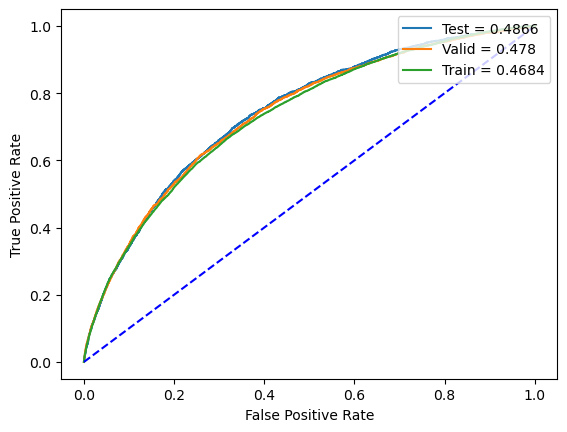

In [35]:
pred_test = log_reg_sm.predict_proba(test_map_w[logit_var_logic_trend])[:, 1]
pred_valid = log_reg_sm.predict_proba(valid_map_w[logit_var_logic_trend])[:, 1]
pred_train = log_reg_sm.predict_proba(train_map_w[logit_var_logic_trend])[:, 1]

plot_roc_curve(true_y = (test_map_w['TARGET'], valid_map_w['TARGET'], train_map_w['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

In [36]:
log_reg_sm.coef_

array([[0.35407416, 0.20976595, 0.17907049, 0.10057559, 0.09627882,
        0.09434772, 0.0631305 , 0.07290189, 0.08038568, 0.08671618,
        0.06803048, 0.0599636 , 0.05290433, 0.0453646 , 0.04085031]])

In [37]:
log_reg_sm.intercept_

array([-2.36363281])

In [38]:
pred_kaggle = log_reg_sm.predict_proba(test_kaggle_map[logit_var_logic_trend])[:, 1]
test_kaggle_map['TARGET'] = pred_kaggle
test_kaggle_map[['SK_ID_CURR', 'TARGET']].head()

,SK_ID_CURR,TARGET
0,100001,0.069764
1,100005,0.103780
2,100013,0.048845
3,100028,0.066314
4,100038,0.116721


In [39]:
test_kaggle_map[['SK_ID_CURR', 'TARGET']].to_csv('submission_logit.csv', index = False)

# Intepretability

## APPS_EXT_SOURCE_MEAN

In [40]:
woeDF[woeDF['Variable'] == 'APPS_EXT_SOURCE_MEAN']

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,APPS_EXT_SOURCE_MEAN,"(-0.0009886, 0.304]",20910,4840.0,0.285041,16070.0,0.083643,1.226081,0.246931
1,APPS_EXT_SOURCE_MEAN,"(0.304, 0.384]",20907,3012.0,0.177385,17895.0,0.093142,0.644203,0.054270
2,APPS_EXT_SOURCE_MEAN,"(0.384, 0.439]",20905,2170.0,0.127797,18735.0,0.097514,0.270454,0.008190
3,APPS_EXT_SOURCE_MEAN,"(0.439, 0.484]",20928,1715.0,0.101001,19213.0,0.100002,0.009946,0.000010
4,APPS_EXT_SOURCE_MEAN,"(0.484, 0.524]",21078,1391.0,0.081920,19687.0,0.102469,-0.223815,0.004599
5,APPS_EXT_SOURCE_MEAN,"(0.524, 0.563]",20794,1124.0,0.066196,19670.0,0.102380,-0.436080,0.015779
6,APPS_EXT_SOURCE_MEAN,"(0.563, 0.603]",20945,890.0,0.052415,20055.0,0.104384,-0.688892,0.035801
7,APPS_EXT_SOURCE_MEAN,"(0.603, 0.644]",20742,798.0,0.046996,19944.0,0.103806,-0.792455,0.045019
8,APPS_EXT_SOURCE_MEAN,"(0.644, 0.692]",21016,618.0,0.036396,20398.0,0.106169,-1.070583,0.074698
9,APPS_EXT_SOURCE_MEAN,"(0.692, 0.879]",20757,409.0,0.024087,20348.0,0.105909,-1.480902,0.121170


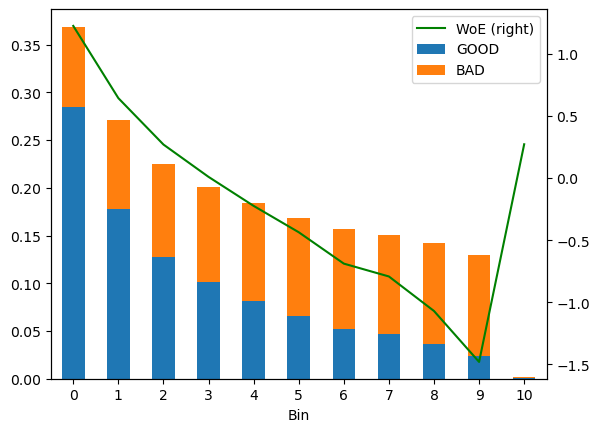

In [41]:
temp = woeDF[woeDF['Variable'] == 'APPS_EXT_SOURCE_MEAN']
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()
# 10 la missing : chi co 115 obs => nhom vao nhom cuoi cung
# # NEW_EXTSOURCE_MEAN cang lon thi khach hang cang bad 

## EXT_SOURCE_3

In [42]:
woeDF[woeDF['Variable'] == 'EXT_SOURCE_3']


,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,EXT_SOURCE_3,"(-0.000473, 0.228]",16870,3376.0,0.198822,13494.0,0.070235,1.040567,0.133804
1,EXT_SOURCE_3,"(0.228, 0.33]",16736,2151.0,0.126678,14585.0,0.075913,0.512060,0.025995
2,EXT_SOURCE_3,"(0.33, 0.408]",17002,1635.0,0.096290,15367.0,0.079984,0.185541,0.003025
3,EXT_SOURCE_3,"(0.408, 0.476]",16796,1346.0,0.079270,15450.0,0.080416,-0.014351,0.000016
4,EXT_SOURCE_3,"(0.476, 0.537]",16827,1048.0,0.061720,15779.0,0.082128,-0.285676,0.005830
5,EXT_SOURCE_3,"(0.537, 0.592]",16871,901.0,0.053062,15970.0,0.083122,-0.448842,0.013492
6,EXT_SOURCE_3,"(0.592, 0.643]",16893,819.0,0.048233,16074.0,0.083663,-0.550754,0.019513
7,EXT_SOURCE_3,"(0.643, 0.694]",16880,734.0,0.043227,16146.0,0.084038,-0.664798,0.027131
8,EXT_SOURCE_3,"(0.694, 0.749]",16057,571.0,0.033628,15486.0,0.080603,-0.874182,0.041065
9,EXT_SOURCE_3,"(0.749, 0.894]",16746,520.0,0.030624,16226.0,0.084455,-1.014421,0.054607


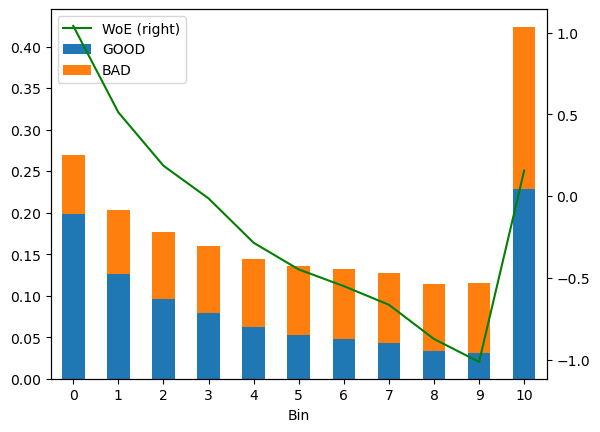

In [43]:
temp = woeDF[woeDF['Variable'] == 'EXT_SOURCE_3']
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()
# Missing la tot

## EXT_SOURCE_2

In [44]:
temp = woeDF[woeDF['Variable'] == 'EXT_SOURCE_2']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,EXT_SOURCE_2,"(-0.0009999404, 0.216]",20866,3833.0,0.225736,17033.0,0.088655,0.934616,0.128118
1,EXT_SOURCE_2,"(0.216, 0.34]",20878,2516.0,0.148174,18362.0,0.095572,0.438507,0.023066
2,EXT_SOURCE_2,"(0.34, 0.44]",20885,2100.0,0.123675,18785.0,0.097774,0.234999,0.006087
3,EXT_SOURCE_2,"(0.44, 0.512]",20939,1763.0,0.103828,19176.0,0.099809,0.039478,0.000159
4,EXT_SOURCE_2,"(0.512, 0.566]",20891,1570.0,0.092462,19321.0,0.100564,-0.083997,0.000681
5,EXT_SOURCE_2,"(0.566, 0.608]",20950,1415.0,0.083333,19535.0,0.101678,-0.198958,0.003650
6,EXT_SOURCE_2,"(0.608, 0.646]",20669,1221.0,0.071908,19448.0,0.101225,-0.341954,0.010025
7,EXT_SOURCE_2,"(0.646, 0.682]",21024,1018.0,0.059953,20006.0,0.104129,-0.552072,0.024388
8,EXT_SOURCE_2,"(0.682, 0.722]",20702,872.0,0.051355,19830.0,0.103213,-0.698041,0.036199
9,EXT_SOURCE_2,"(0.722, 0.855]",20856,634.0,0.037338,20222.0,0.105253,-1.036357,0.070384


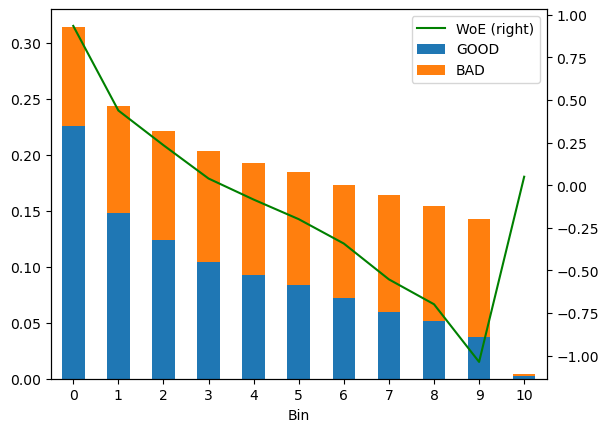

In [45]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## EXT_SOURCE_1

In [46]:
temp = woeDF[woeDF['Variable'] == 'EXT_SOURCE_1']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,EXT_SOURCE_1,"(0.013600000000000001, 0.212]",9135,1554.0,0.091519,7581.0,0.039458,0.841308,0.043799
1,EXT_SOURCE_1,"(0.212, 0.296]",9139,1062.0,0.062544,8077.0,0.042040,0.397254,0.008145
2,EXT_SOURCE_1,"(0.296, 0.369]",9122,830.0,0.048881,8292.0,0.043159,0.124500,0.000712
3,EXT_SOURCE_1,"(0.369, 0.438]",9114,763.0,0.044935,8351.0,0.043466,0.033242,0.000049
4,EXT_SOURCE_1,"(0.438, 0.505]",9155,625.0,0.036808,8530.0,0.044398,-0.187473,0.001423
5,EXT_SOURCE_1,"(0.505, 0.573]",9104,568.0,0.033451,8536.0,0.044429,-0.283806,0.003116
6,EXT_SOURCE_1,"(0.573, 0.639]",9122,469.0,0.027621,8653.0,0.045038,-0.488938,0.008516
7,EXT_SOURCE_1,"(0.639, 0.709]",9140,397.0,0.023380,8743.0,0.045506,-0.665952,0.014735
8,EXT_SOURCE_1,"(0.709, 0.787]",9108,321.0,0.018905,8787.0,0.045735,-0.883467,0.023704
9,EXT_SOURCE_1,"(0.787, 0.963]",9111,232.0,0.013663,8879.0,0.046214,-1.218586,0.039666


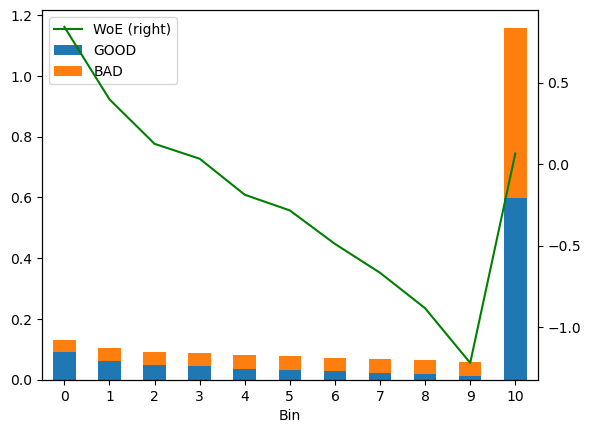

In [47]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN

In [48]:
temp = woeDF[woeDF['Variable'] == 'BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(-inf, 0.0]",47233,2646.0,0.155830,44587.0,0.232070,-0.398273,0.030364
1,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.0, 0.0377]",4051,182.0,0.010718,3869.0,0.020138,-0.630624,0.005940
2,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.0377, 0.126]",17094,819.0,0.048233,16275.0,0.084710,-0.563181,0.020543
3,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.126, 0.189]",17095,1000.0,0.058893,16095.0,0.083773,-0.352388,0.008767
4,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.189, 0.252]",17094,1179.0,0.069435,15915.0,0.082836,-0.176475,0.002365
5,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.252, 0.329]",17094,1395.0,0.082155,15699.0,0.081712,0.005418,0.000002
6,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.329, 0.439]",17095,1708.0,0.100589,15387.0,0.080088,0.227921,0.004673
7,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.439, 0.617]",17094,1993.0,0.117373,15101.0,0.078599,0.401001,0.015549
8,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.617, inf]",17095,2365.0,0.139282,14730.0,0.076668,0.597012,0.037381
9,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,Missing,38162,3693.0,0.217491,34469.0,0.179407,0.192499,0.007331


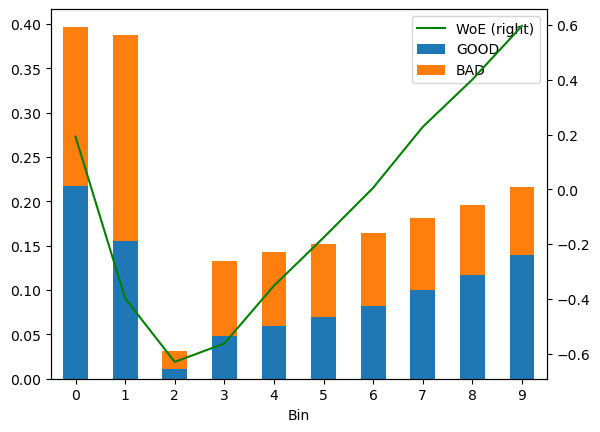

In [49]:
temp = woeDF[woeDF['Variable'] == 'BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN']
temp['Bin']= [i for i in range(temp.shape[0])] 
temp.loc[9, 'Bin'] = -1
temp = temp.sort_values(by = ['Bin'])
temp = temp.reset_index().drop(columns = ['index'])
temp['Bin'] = [i for i in range(temp.shape[0])] 

temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()
## Cut off tai diem 0

## BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x

In [50]:
temp = woeDF[woeDF['Variable'] == 'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(-inf, 0.0152]",13816,718.0,0.042285,13098.0,0.068174,-0.477625,0.012365
1,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(0.0152, 0.428]",13815,715.0,0.042108,13100.0,0.068184,-0.481965,0.012568
2,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(0.428, 0.654]",13815,710.0,0.041814,13105.0,0.068210,-0.489364,0.012917
3,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(0.654, 0.787]",13815,829.0,0.048822,12986.0,0.067591,-0.325287,0.006105
4,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(0.787, 0.868]",13815,939.0,0.055300,12876.0,0.067018,-0.192184,0.002252
5,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(0.868, 0.922]",13815,1046.0,0.061602,12769.0,0.066461,-0.075927,0.000369
6,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(0.922, 0.956]",13815,1316.0,0.077503,12499.0,0.065056,0.175069,0.002179
7,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(0.956, 0.989]",13815,1499.0,0.088280,12316.0,0.064103,0.320019,0.007737
8,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(0.989, 1.003]",13815,1557.0,0.091696,12258.0,0.063802,0.362703,0.010117
9,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(1.003, inf]",13815,2167.0,0.127621,11648.0,0.060627,0.744330,0.049866


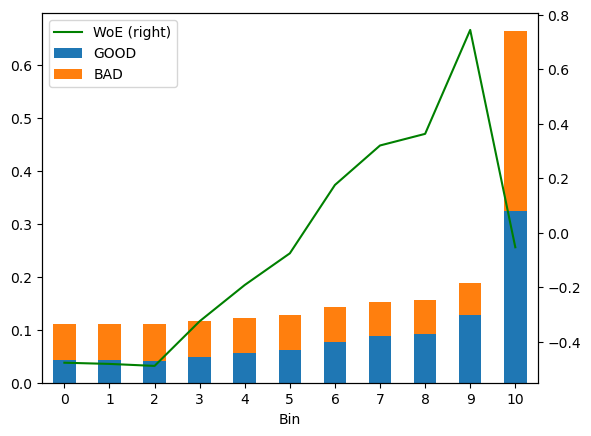

In [51]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y

In [52]:
# BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y
temp = woeDF[woeDF['Variable'] == 'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,"(-inf, 0.0]",28260,1504.0,0.088575,26756.0,0.139262,-0.452510,0.022936
1,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,"(0.0, 0.463]",12323,707.0,0.041637,11616.0,0.060460,-0.372988,0.007021
2,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,"(0.463, 0.702]",13528,774.0,0.045583,12754.0,0.066383,-0.375908,0.007819
3,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,"(0.702, 0.82]",13527,915.0,0.053887,12612.0,0.065644,-0.197360,0.002320
4,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,"(0.82, 0.89]",13528,1019.0,0.060012,12509.0,0.065108,-0.081506,0.000415
5,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,"(0.89, 0.937]",13527,1207.0,0.071084,12320.0,0.064124,0.103034,0.000717
6,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,"(0.937, 0.972]",13530,1495.0,0.088045,12035.0,0.062641,0.340428,0.008648
7,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,"(0.972, 1.0]",16600,1886.0,0.111072,14714.0,0.076585,0.371779,0.012822
8,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,"(1.0, inf]",10453,1790.0,0.105418,8663.0,0.045090,0.849275,0.051235
9,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,Missing,73831,5683.0,0.334688,68148.0,0.354703,-0.058082,0.001163


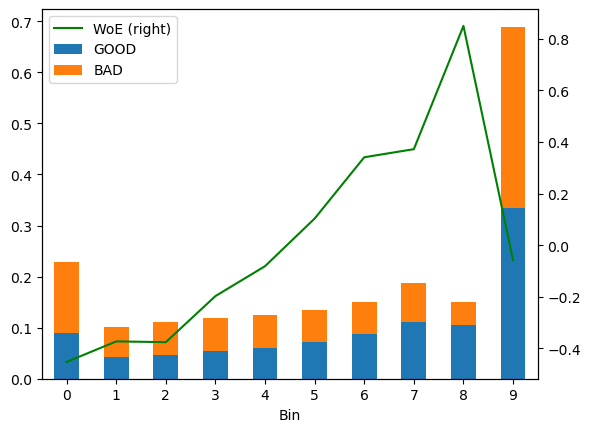

In [53]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## DAYS_BIRTH

In [54]:
# DAYS_BIRTH
temp = woeDF[woeDF['Variable'] == 'DAYS_BIRTH']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,DAYS_BIRTH,"(-25200.001, -22179.0]",20915,1006.0,0.059246,19909.0,0.103624,-0.559069,0.024810
1,DAYS_BIRTH,"(-22179.0, -20467.0]",20908,1161.0,0.068375,19747.0,0.102781,-0.407599,0.014024
2,DAYS_BIRTH,"(-20467.0, -18875.0]",20913,1333.0,0.078504,19580.0,0.101912,-0.260956,0.006108
3,DAYS_BIRTH,"(-18875.0, -17216.0]",20916,1514.0,0.089164,19402.0,0.100985,-0.124501,0.001472
4,DAYS_BIRTH,"(-17216.0, -15752.0]",20911,1655.0,0.097468,19256.0,0.100225,-0.027901,0.000077
5,DAYS_BIRTH,"(-15752.0, -14410.0]",20902,1674.0,0.098587,19228.0,0.100080,-0.015031,0.000022
6,DAYS_BIRTH,"(-14410.0, -13134.0]",20917,1869.0,0.110071,19048.0,0.099143,0.104562,0.001143
7,DAYS_BIRTH,"(-13134.0, -11690.0]",20916,2045.0,0.120436,18871.0,0.098221,0.203892,0.004529
8,DAYS_BIRTH,"(-11690.0, -10282.0]",20908,2304.0,0.135689,18604.0,0.096832,0.337391,0.013110
9,DAYS_BIRTH,"(-10282.0, -7673.0]",20901,2419.0,0.142462,18482.0,0.096197,0.392677,0.018167


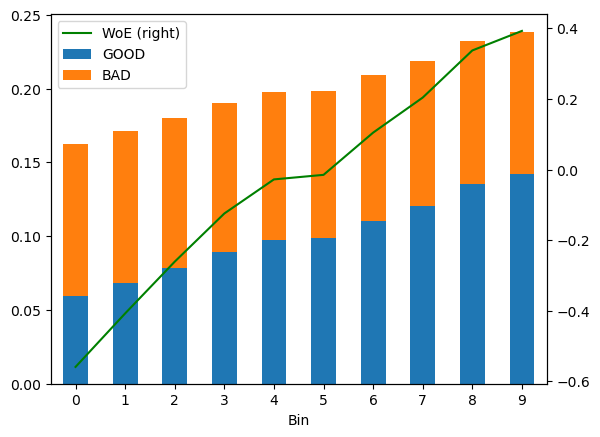

In [55]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## CARD_M3BALANCE_LIMIT_RATIO_MAX

In [56]:
# CARD_M3BALANCE_LIMIT_RATIO_MAX

temp = woeDF[woeDF['Variable'] == 'CARD_M3BALANCE_LIMIT_RATIO_MAX']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,CARD_M3BALANCE_LIMIT_RATIO_MAX,"(-0.001, 0.46]",26741,1559.0,0.091814,25182.0,0.131070,-0.355964,0.013974
1,CARD_M3BALANCE_LIMIT_RATIO_MAX,"(0.46, 0.89]",4457,343.0,0.020200,4114.0,0.021413,-0.058300,0.000071
2,CARD_M3BALANCE_LIMIT_RATIO_MAX,"(0.89, 0.988]",4457,583.0,0.034335,3874.0,0.020164,0.532265,0.007543
3,CARD_M3BALANCE_LIMIT_RATIO_MAX,"(0.988, 1.035]",4457,699.0,0.041166,3758.0,0.019560,0.744129,0.016078
4,CARD_M3BALANCE_LIMIT_RATIO_MAX,"(1.035, inf]",4457,945.0,0.055654,3512.0,0.018280,1.113364,0.041611
5,CARD_M3BALANCE_LIMIT_RATIO_MAX,Missing,164538,12851.0,0.756832,151687.0,0.789514,-0.042277,0.001382


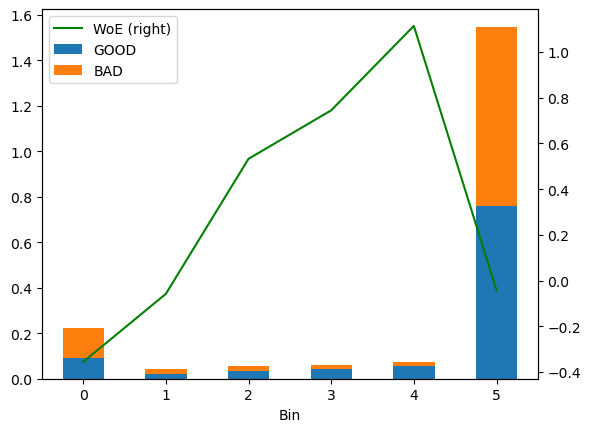

In [57]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## INS_D365SK_DPD_MAX

In [58]:
# INS_D365SK_DPD_MAX
temp = woeDF[woeDF['Variable'] == 'INS_D365SK_DPD_MAX']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,INS_D365SK_DPD_MAX,"(-325.001, -12.0]",15097,957.0,0.056360,14140.0,0.073597,-0.266839,0.004599
1,INS_D365SK_DPD_MAX,"(-12.0, -8.0]",15099,909.0,0.053534,14190.0,0.073857,-0.321827,0.006541
2,INS_D365SK_DPD_MAX,"(-8.0, -4.0]",17714,1153.0,0.067903,16561.0,0.086198,-0.238563,0.004364
3,INS_D365SK_DPD_MAX,"(-4.0, -2.0]",12332,792.0,0.046643,11540.0,0.060064,-0.252893,0.003394
4,INS_D365SK_DPD_MAX,"(-2.0, 0.0]",43738,3138.0,0.184806,40600.0,0.211319,-0.134062,0.003554
5,INS_D365SK_DPD_MAX,"(0.0, 2.0]",15064,1451.0,0.085453,13613.0,0.070854,0.187348,0.002735
6,INS_D365SK_DPD_MAX,"(2.0, 5.0]",13364,1428.0,0.084099,11936.0,0.062126,0.302836,0.006654
7,INS_D365SK_DPD_MAX,"(5.0, 2884.0]",14395,2217.0,0.130565,12178.0,0.063385,0.722644,0.048547
8,INS_D365SK_DPD_MAX,Missing,62304,4935.0,0.290636,57369.0,0.298599,-0.027031,0.000215


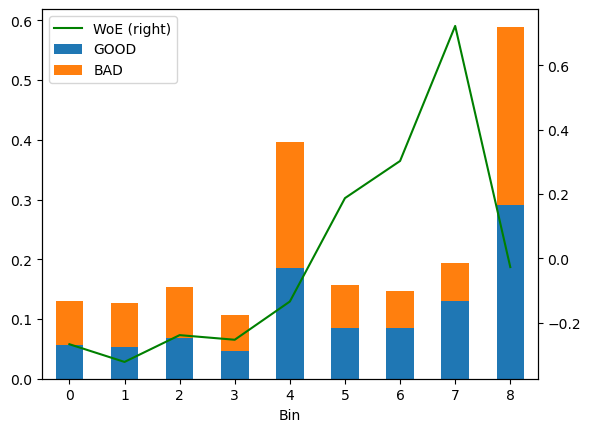

In [59]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## APPS_GOODS_CREDIT_RATIO

In [60]:
# APPS_GOODS_CREDIT_RATIO
# get_apps_processed : APPS_GOODS_CREDIT_RATIO : apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT'] : consumer's loan ratio of credit amount

temp = woeDF[woeDF['Variable'] == 'APPS_GOODS_CREDIT_RATIO']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,APPS_GOODS_CREDIT_RATIO,"(0.166, 0.783]",20954,2674.0,0.157479,18280.0,0.095145,0.503888,0.031409
1,APPS_GOODS_CREDIT_RATIO,"(0.783, 0.826]",21505,2407.0,0.141755,19098.0,0.099403,0.354918,0.015031
2,APPS_GOODS_CREDIT_RATIO,"(0.826, 0.857]",20219,1864.0,0.109776,18355.0,0.095536,0.138943,0.001979
3,APPS_GOODS_CREDIT_RATIO,"(0.857, 0.873]",21858,1826.0,0.107538,20032.0,0.104264,0.030917,0.000101
4,APPS_GOODS_CREDIT_RATIO,"(0.873, 0.894]",22717,1488.0,0.087633,21229.0,0.110495,-0.231815,0.005300
5,APPS_GOODS_CREDIT_RATIO,"(0.894, 0.927]",18237,1257.0,0.074028,16980.0,0.088379,-0.177188,0.002543
6,APPS_GOODS_CREDIT_RATIO,"(0.927, 1.0]",83253,5440.0,0.320377,77813.0,0.405008,-0.234409,0.019838
7,APPS_GOODS_CREDIT_RATIO,"(1.0, 6.667]",182,8.0,0.000471,174.0,0.000906,-0.653493,0.000284
8,APPS_GOODS_CREDIT_RATIO,Missing,182,16.0,0.000942,166.0,0.000864,0.086721,0.000007


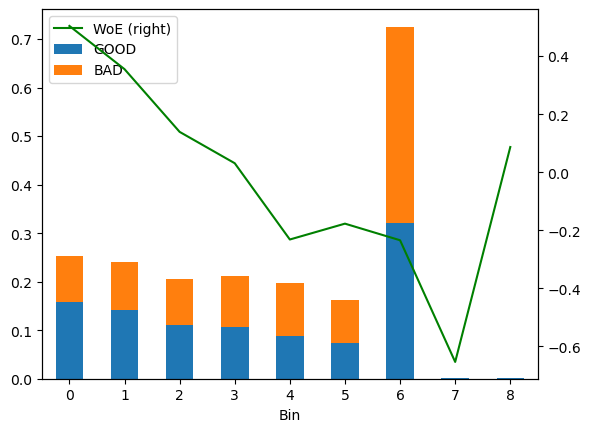

In [61]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## PREV_REFUSED_RATIO

In [62]:
# PREV_REFUSED_RATIO
temp = woeDF[woeDF['Variable'] == 'PREV_REFUSED_RATIO']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,PREV_REFUSED_RATIO,"(-0.001, 0.143]",140584,10060.0,0.592462,130524.0,0.679363,-0.136870,0.011894
1,PREV_REFUSED_RATIO,"(0.143, 0.25]",21119,1824.0,0.107420,19295.0,0.100428,0.067306,0.000471
2,PREV_REFUSED_RATIO,"(0.25, 0.4]",17792,1900.0,0.111896,15892.0,0.082716,0.302158,0.008817
3,PREV_REFUSED_RATIO,"(0.4, 1.0]",18127,2521.0,0.148469,15606.0,0.081228,0.603121,0.040555
4,PREV_REFUSED_RATIO,Missing,11485,675.0,0.039753,10810.0,0.056265,-0.347394,0.005736


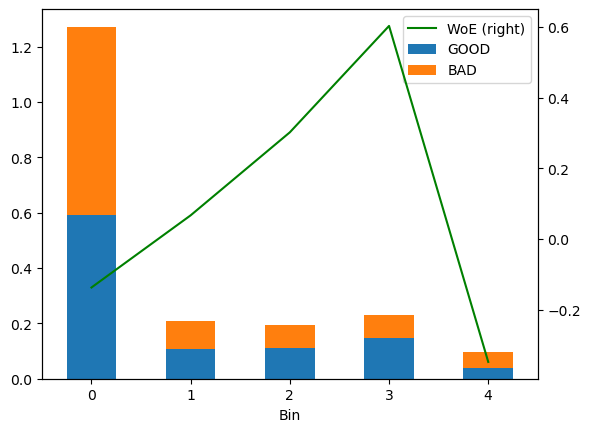

In [63]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## INS_INS_IS_DPD_UNDER_120_MEAN

In [64]:
# INS_INS_IS_DPD_UNDER_120_MEAN
temp = woeDF[woeDF['Variable'] == 'INS_INS_IS_DPD_UNDER_120_MEAN']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,INS_INS_IS_DPD_UNDER_120_MEAN,"(-0.001, 0.0174]",99176,6786.0,0.399647,92390.0,0.480880,-0.185037,0.015031
1,INS_INS_IS_DPD_UNDER_120_MEAN,"(0.0174, 0.0476]",20287,1482.0,0.087279,18805.0,0.097878,-0.114610,0.001215
2,INS_INS_IS_DPD_UNDER_120_MEAN,"(0.0476, 0.0857]",19514,1681.0,0.098999,17833.0,0.092819,0.064459,0.000398
3,INS_INS_IS_DPD_UNDER_120_MEAN,"(0.0857, 0.143]",20478,1982.0,0.116726,18496.0,0.096270,0.192672,0.003941
4,INS_INS_IS_DPD_UNDER_120_MEAN,"(0.143, 0.237]",19031,1904.0,0.112132,17127.0,0.089144,0.229421,0.005274
5,INS_INS_IS_DPD_UNDER_120_MEAN,"(0.237, 1.0]",19819,2498.0,0.147114,17321.0,0.090154,0.489691,0.027893
6,INS_INS_IS_DPD_UNDER_120_MEAN,Missing,10802,647.0,0.038104,10155.0,0.052856,-0.327255,0.004828


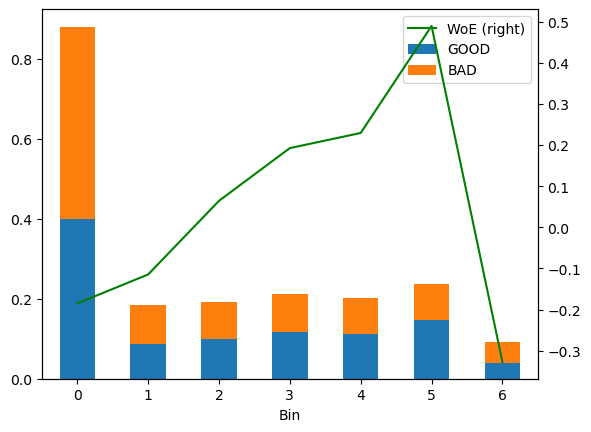

In [65]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## INS_D365AMT_RATIO_MEAN

In [66]:
# NAME_INCOME_TYPE
temp = woeDF[woeDF['Variable'] == 'INS_D365AMT_RATIO_MEAN']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,INS_D365AMT_RATIO_MEAN,"(-0.0009214000000000001, 0.9]",14682,1945.0,0.114547,12737.0,0.066295,0.546871,0.026388
1,INS_D365AMT_RATIO_MEAN,"(0.9, 0.996]",14679,1720.0,0.101296,12959.0,0.067450,0.406654,0.013763
2,INS_D365AMT_RATIO_MEAN,"(0.996, 1.0]",103490,7563.0,0.445406,95927.0,0.499290,-0.114199,0.006153
3,INS_D365AMT_RATIO_MEAN,"(1.0, 3376.3]",13952,817.0,0.048115,13135.0,0.068366,-0.351276,0.007114
4,INS_D365AMT_RATIO_MEAN,Missing,62304,4935.0,0.290636,57369.0,0.298599,-0.027031,0.000215


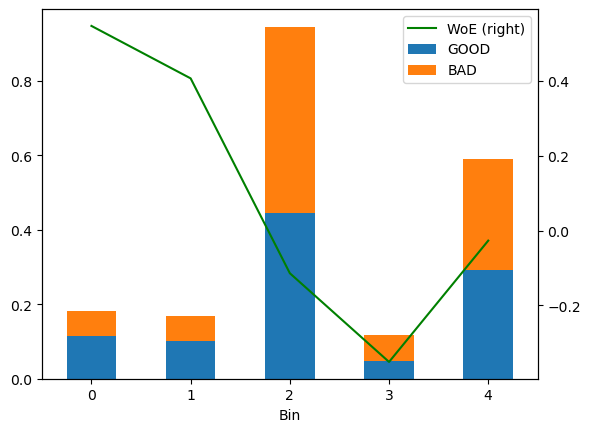

In [67]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## REGION_RATING_CLIENT_W_CITY

In [68]:
train['REGION_RATING_CLIENT_W_CITY'].value_counts()

2    156026
3     29768
1     23313
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64

In [69]:
temp = woeDF[woeDF['Variable'] == 'REGION_RATING_CLIENT_W_CITY']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,REGION_RATING_CLIENT_W_CITY,1,23313,1118.0,0.065842,22195.0,0.115523,-0.562205,0.027931
1,REGION_RATING_CLIENT_W_CITY,2,156026,12399.0,0.730212,143627.0,0.747563,-0.023483,0.000407
2,REGION_RATING_CLIENT_W_CITY,3,29768,3463.0,0.203946,26305.0,0.136915,0.398497,0.026712


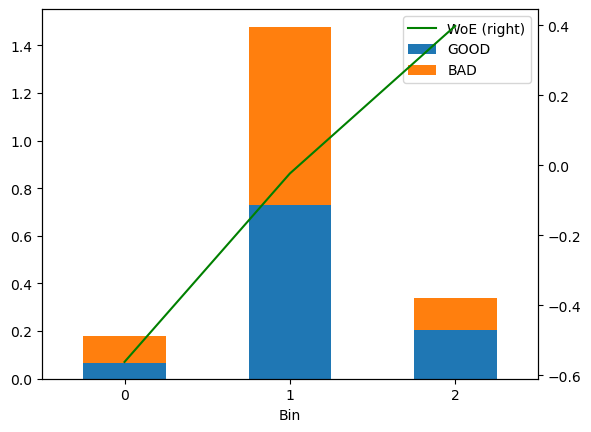

In [70]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## CARD_CNT_DRAWINGS_CURRENT_MAX

In [71]:
train['CARD_CNT_DRAWINGS_CURRENT_MAX'].value_counts()

0.0      18855
4.0       4532
3.0       4377
2.0       3674
5.0       3620
         ...  
96.0         1
103.0        1
104.0        1
112.0        1
111.0        1
Name: CARD_CNT_DRAWINGS_CURRENT_MAX, Length: 113, dtype: int64

In [72]:
temp = woeDF[woeDF['Variable'] == 'CARD_CNT_DRAWINGS_CURRENT_MAX']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,CARD_CNT_DRAWINGS_CURRENT_MAX,"(-0.001, 2.0]",25224,1502.0,0.088457,23722.0,0.123470,-0.333485,0.011676
1,CARD_CNT_DRAWINGS_CURRENT_MAX,"(2.0, 3.0]",4377,329.0,0.019376,4048.0,0.021069,-0.083800,0.000142
2,CARD_CNT_DRAWINGS_CURRENT_MAX,"(3.0, 5.0]",8152,693.0,0.040813,7459.0,0.038823,0.049974,0.000099
3,CARD_CNT_DRAWINGS_CURRENT_MAX,"(5.0, 7.0]",5101,494.0,0.029093,4607.0,0.023979,0.193324,0.000989
4,CARD_CNT_DRAWINGS_CURRENT_MAX,"(7.0, 10.0]",4661,513.0,0.030212,4148.0,0.021590,0.336015,0.002897
5,CARD_CNT_DRAWINGS_CURRENT_MAX,"(10.0, 18.0]",5716,747.0,0.043993,4969.0,0.025863,0.531212,0.009631
6,CARD_CNT_DRAWINGS_CURRENT_MAX,"(18.0, 162.0]",5778,897.0,0.052827,4881.0,0.025405,0.732071,0.020075
7,CARD_CNT_DRAWINGS_CURRENT_MAX,Missing,150098,11805.0,0.695230,138293.0,0.719800,-0.034731,0.000853


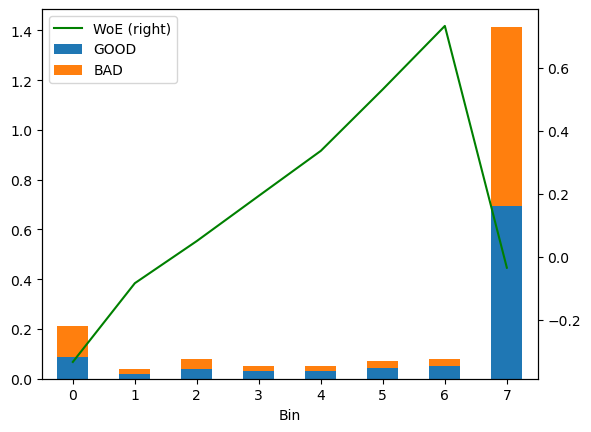

In [73]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()